# Vorlesung: Clustering eines Diagramm-Typs

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn import decomposition

from medDiaJson import diaTypeGrid, diaTypeDescr
from IPython.display import HTML

In [2]:
np.set_printoptions(formatter={'float':lambda x: format(x,'.2f')})

In [3]:
%matplotlib notebook

## Beschreibung der Sammlung

Diese Vorlesung bezieht sich auf eine Sammlung mittelalterlicher Diagramme mit dem thematischen Fokus auf der Bewegung von Planeten. Jedes Diagramm wurde gescannt und in Unterkategorien eingeordnet. Jeder Diagramm-Typ wurde dann auf das vorhanden-sein oder fehlen von spezifischen Merkmalen untersucht. So entstand eine Datenbank mit Kategorien für Diagramm-Typ, Diagramm-Attributen, usw. Auf diese Datenbank können wir über Github zugreifen. 

In [4]:
url = 'https://raw.githubusercontent.com/computational-humanities/topoi/master/projects/medievaldiagrams/data/diaattr.json'
url2 = 'https://raw.githubusercontent.com/computational-humanities/topoi/master/projects/medievaldiagrams/data/MedievalDiagrams_DB.json'
diagrams = pd.read_json(url)
diagrams.head()

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
0,Plin4,Plinius,"Vaticano BAV, Ross. 247","[{'M2.9': 0, 'M2.8': 1, 'M2.23': 0, 'M2.4': 0,...",MAPD0668,2,Dl_1&pn=396&dw=1858&dh=901&ww=0.8926&wh=0.6552...,200v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
1,Plin41,Plinius,"Vaticano BAV, Ross. 247","[{'M3.8': 0, 'M3.26': 0, 'M3.11': 0, 'M3.15': ...",MAPD0670,3,Dl_1&pn=395&dw=1858&dh=901&ww=0.9617&wh=0.7723...,200r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
2,Plin67,Plinius,"Vaticano BAV, Ross. 247","[{'M4.7': 0, 'M4.1': 0, 'M4.4': 0, 'M4.6': 0, ...",MAPD0698,4,Dl_1&pn=414&dw=1858&dh=901&ww=0.9085&wh=0.6452...,209v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
3,Plin82,Plinius,"Vaticano BAV, Ross. 247","[{'M6.10': 1, 'M6.17': 1, 'M6.3': 1, 'M6.9': 0...",MAPD0714,6,Dl_1&pn=393&dw=1858&dh=901&ww=0.8255&wh=0.62&w...,199r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
4,Plin6,Plinius,"Paris BN, 11130","[{'M2.9': 0, 'M2.8': 1, 'M2.23': 0, 'M2.4': 1,...",MAPD0690,2,Jk_2&pn=1&dw=1858&dh=901&ww=1&wh=1&wx=0&wy=0,74v,JK(2),Jk_2&pn=1,JK(2)_A,,XII


### Beschreibung des Diagramm-Typs

Die Erklärung des Diagramm-Typs erhält man aus der Datenbank über den Befehl

In [5]:
print(diaTypeDescr(22))

Circumsolar Intersecting (Circumsolar intersecting)
An arrangement with Venus and Mercury on intersecting circles around the Sun. In this type of diagram Venus usually appears on the outermost circle in the pattern, producing the resultant planetary sequence from the Moon outward: Mercury -- Venus - Sun -- Mercury -- Venus. The two intersecting circles are usually about the same size, although the circle of Venus may be significantly larger than that of Mercury. The Sun may appear either on an arc or on its full circle. The earth may or may not appear as the body around which the Sun revolves. This diagram may or may not include further planetary circles or the zodiacal circle. The diagram is not connected to any other planetary diagram in the way that the elements of the "Three versions" are connected. See description and text for "Three versions" (above).


## Merkmale einzelner Diagramme

Wir reduzieren die Datenbank auf den Diagramm-Typ des Authors Martianus Capella mit der größten Verteilung in den Manuskripten. 

In [6]:
dfCapella = diagrams[(diagrams['author']=='Capella') & (diagrams['diaTyp']==22)].reset_index(drop=True)

In [7]:
dfAttr = pd.DataFrame(dict(dfCapella['diaAttr'].apply(lambda row: row[0]))).transpose()
dfAttr.replace(['?'],[0],inplace=True)

In [8]:
dfCapellaAttr = dfCapella.join(dfAttr)
dfCapellaAttr.head()

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year,M22.1,M22.2,M22.3,M22.4,M22.5,M22.6
0,Cape149,Capella,"Leiden UB, Ms BPL 64","[{'M22.5': 1, 'M22.4': 0, 'M22.1': 0, 'M22.2':...",MAPD0345,22,Lk_1&pn=92&dw=1858&dh=901&ww=0.7615&wh=0.3906&...,46v,LK(1),Lk_1&pn=1,LK(1)_B,,XI,0,1,0,0,1,0
1,Cape34,Capella,"Vaticano BAV, Ms Regin. lat. 1987","[{'M22.5': 0, 'M22.4': 1, 'M22.1': 1, 'M22.2':...",MAPD0397,22,Ay_3&pn=122&dw=1858&dh=901&ww=0.062&wh=0.1081&...,128r,AY(3),Ay_3&pn=1,AY(3)_A,,IX(ex),1,0,1,1,0,0
2,Cape39,Capella,"Erfurt StB, Ms Amplon. Q.351","[{'M22.5': 0, 'M22.4': 1, 'M22.1': 0, 'M22.2':...",MAPD0402,22,Bn_3&pn=15&dw=1858&dh=901&ww=0.1803&wh=0.2756&...,13v,BN(3),Bn_3&pn=1,BN(3)_A,,XII,0,0,1,1,0,1
3,Cape35,Capella,"Leiden UB, BPL, 88","[{'M22.5': 0, 'M22.4': 1, 'M22.1': 1, 'M22.2':...",MAPD0398,22,Ba_2&pn=323&dw=1858&dh=901&ww=0.1131&wh=0.1007...,162v,BA(2),Ba_2&pn=1,BA(2)_A,,IX,1,0,1,1,0,0
4,Cape36,Capella,"Leiden UB, BPL, 87","[{'M22.5': 0, 'M22.4': 0, 'M22.1': 1, 'M22.2':...",MAPD0399,22,Ba_3&pn=126&dw=1858&dh=901&ww=0.1108&wh=0.2035...,124v,BA(3),Ba_3&pn=1,BA(3)_A,,IX,1,0,1,0,0,0


Wir erhalten eine binäre Matrix (eins und null Einträge), indem wir nur die Spalten der Diagramm-Attribute auswählen und den Befehl `dataframe.values` anwenden. Jedes Diagramm wird dann durch eine Zeile der Matrix über seine vorhandenen und nicht vorhandenen Merkmale beschrieben. 

In [9]:
X = dfAttr.values.astype(int)
X

array([[0, 1, 0, 0, 1, 0],
       [1, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0]])

Die Matrix, welche unsere Datenpunkte beschreibt, hat die Dimension X = (Zeilen) x (Spalten) = 14 x 6. Wir haben also für unsere 14 Datenpunkte je 6 Merkmale. 

## Abstände der Ähnlichkeiten von Diagrammen
### Hamming Distanz

Für die Cluster-Analyse wird nun für alle Datenpunkte der Abstand zueinander berechnet. Hierbei nutzen wir die `linkage` Routine aus dem scipy-Paket. Nun kommt es auf die Methode und die Metrik an, wie genau der Abstand zweier Datenpunkte berechnet wird. 

Die Methode beschreibt sozusagen, an welchen Orten zweier Cluster das Maßband zur Abstandmessung angelegt wird. Zum Beispiel können einfach die jenigen Punkte der Cluster ausgewählt werden, die am nächsten Liegen (`single`) oder auch die am weitesten entfernten (`complete`). Auch üblich ist es, den Schwerpunkt aller Punkte eines Clusters zu nehmen (`average`).

Da unsere Beschreibungs-Vektoren der Diagramme binär sind, bietet sich eine Metrik für binäre Zahlen an. Ein prominentes Beispiel ist der Hamming-Abstand `h(u,v)`. Er beschreibt, an wie vielen Stellen sich zwei gleichlange Vektoren **`u`** und **`v`** unterscheiden. So ist zum Beispiel der Abstand von **u**=(1,1,0,0,1) zu **v**=(1,1,1,0,1), `h(u,v)`=1/5, weil sich die beiden Vektoren nur an der dritten Stelle unterscheiden. Dieser Abstand kann auch auf Wörter angewendet werden, so ist zum Beispiel h(Baum,Haus)=2/4=0.5, da sich B und H und m und s unterscheiden.

Für den Diagramm-Typ 22 haben wir 14 Diagramme in unserer Datenpunkt-Matrix. 

In [10]:
len(X)

14

Um aus allen einzelnen Diagrammen einen Gesamt-Cluster zu bilden, brauchen wir (N-1)=13 Schritte , in denen zwei Diagramme oder Cluster zu einem neuen Cluster zusammengefasst werden. 

Wir wenden nun den Hamming-Abstand mit der Schwerpunkt-Methode an, um eine Cluster-Analyse durchzuführen.

In [11]:
Z = linkage(X, method='average', metric='hamming')
Z

array([[0.00, 9.00, 0.00, 2.00],
       [10.00, 14.00, 0.00, 3.00],
       [5.00, 7.00, 0.00, 2.00],
       [8.00, 16.00, 0.00, 3.00],
       [4.00, 12.00, 0.00, 2.00],
       [13.00, 18.00, 0.00, 3.00],
       [1.00, 3.00, 0.00, 2.00],
       [11.00, 15.00, 0.17, 4.00],
       [19.00, 20.00, 0.17, 5.00],
       [17.00, 21.00, 0.29, 7.00],
       [6.00, 23.00, 0.31, 8.00],
       [2.00, 22.00, 0.43, 6.00],
       [24.00, 25.00, 0.60, 14.00]])

### Einzelne Schritte der Cluster-Bildung

In der Matrix Z stehen nun alle (N-1)=13 Einträge der Cluster-Bildung, die nötig waren, um am Ende einen einzigen Cluster zu erhalten. 

In den ersten Schritten des Algorithmus werden Diagramme mit Abstand Null zu größeren Clustern zusammen gefasst. Da einige Diagramme den selben Abstand Null haben, also genau die selben Merkmanle haben, ist die Reihenfolge des Zusammenfassens in Z zufällig. 

Durch den Aufruf `Z[0,:]` erhält man den ersten Schritt der Cluster-Bildung. Die ersten beiden Einträge bezeichnen die Diagramme, die zusammengefasst wurden. Der dritte Eintrag enthält die Entfernung der beiden Diagramme zueinander und der letzte, vierte, Eintrag beschreint die Größe des neu entstandenen Clusters. Die neu entstandenen Cluster werden mit N+1,N+2 usw durchnummeriert. Steht also in einem Eintrag in Z, dass zum Beispiel Diagram 0 mit 14 zusammengefasst wurden, handelt es sich bei dem Eintrag 14 um einen Cluster.

In den ersten sieben Schritten werden nur Diagramme bzw Cluster mit Abstand Null zusammengefasst.

Erst im achten Schritt wird ein einzelnes Diagramm mit einem neuen Cluster zusammengefasst, der einen Hamming-Abstand von 0.17 hat.

In [12]:
Z[7,:]

array([11.00, 15.00, 0.17, 4.00])

## Dendrogramm

Der gesamte Prozess der Cluster-Bildung lässt sich am besten mittels eines Dendrogramms (Baum-Diagram) darstellen. Hier ist der entstandene Gesamt-Cluster die Wurzel eines Baumes, der sich in immer mehr Zweige (Cluster) verzweigt, bis er schließlich nur noch die einzelnen Diagramme als Blätter enthält. Die y-Achse beschreibt den Hamming-Abstand, während auf der x-Achse die einzelnen Diagramme abgetragen sind.

Da einzelne Diagramme schon bei einem Abstand von Null zusammengefasst werden, sind nicht alle Blätter des Baumes bei einem Diagramm Index. So sind ja zum Beispiel in den ersten zwei Schritten schon drei Diagramme in einem Cluster zusammengefasst worden. Daher ist die rote Linie etwas neben dem Index 0. Auch Diagramme 4 und 6 wurden bei Abstand Null zusammengefasst. Daher ist die dunkel blaue Linie genau zwischen den beiden Indices.

<IPython.core.display.Javascript object>


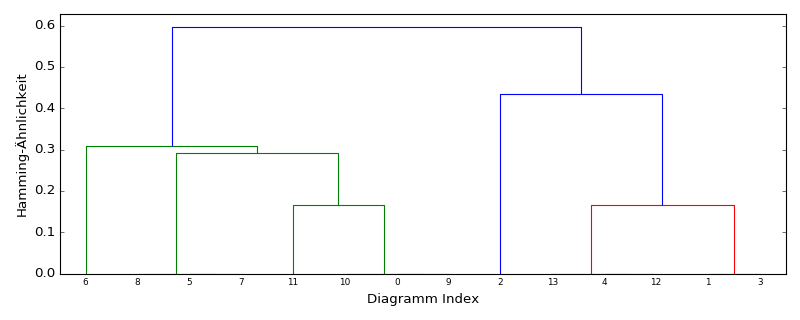

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10, 4),sharey=True,sharex=True)

fig.set_label('Hierarchische Cluster-Analyse')
fig.set_tight_layout(True)
plt.xlabel('Diagramm Index')
plt.ylabel('Hamming-Ähnlichkeit')
dendrogram(
    Z,
    leaf_font_size=8.,  # font size for the x axis labels
    ax=ax
);


### Anzeigen der Diagramme zwei Indices

Um die Cluster-Bildung nachvollziehen zu können, können mit folgender Funktion zwei Bilder von Diagrammen über ihren Index abgerufen werden.

In [14]:
def idx2image(dataframe, index1,index2):
    diaID1 = dfCapellaAttr['diaID'].iloc[index1]
    diaID2 = dfCapellaAttr['diaID'].iloc[index2]
    url_start = 'http://repository.edition-topoi.org/digilib/digilib.html?fn=/MAPD/ReposMAPD/EastwoodCollection/'
    url_end1 = dataframe[dataframe['diaID']==diaID1].reset_index(drop=True)['diaURL'][0]
    url_end2 = dataframe[dataframe['diaID']==diaID2].reset_index(drop=True)['diaURL'][0]
    return HTML('<iframe src=' + url_start + url_end1 + ' + width=400 height=400></iframe><iframe src=' + url_start + url_end2 + ' + width=400 height=400></iframe>')

In [15]:
idx2image(diagrams, 1,3)

## Cut-Off wählen

Die Cluster-Analyse dient ja im allgemeinen dazu, Struktur in ungeordneten Daten zu erkennen. Daher ist es nicht sinnvoll, den resultierenden Gesamt-Cluster zu untersuchen. Er enthält keine Strukturinformationen mehr. Wir müssen daher einen Cut-Off für den Cluster-Prozess wählen. Dieser muss so gewählt werden, dass weder zu viele noch zu wenige Cluster entstehen. Im obigen Dendrogramm bietet sich ein Cutt-Off bei einem Hamming-Abstand von 0.35 an. Dadurch erhalten wir drei Cluster, die wir in unserer Projektion einfärben können.

In [16]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.35
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2], dtype=int32)

## Diagramme nach Clustern-Zugehörigkeit markieren 

Für unseren Dataframe können wir eine neue Spalte mit der Cluster-ID erzeugen und so eine Einordnung der Diagramme erhalten.

In [17]:
dfCapellaAttr['clustID'] = clusters

In [18]:
dfCapellaAttr.sort_values('clustID').head()

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year,M22.1,M22.2,M22.3,M22.4,M22.5,M22.6,clustID
0,Cape149,Capella,"Leiden UB, Ms BPL 64","[{'M22.5': 1, 'M22.4': 0, 'M22.1': 0, 'M22.2':...",MAPD0345,22,Lk_1&pn=92&dw=1858&dh=901&ww=0.7615&wh=0.3906&...,46v,LK(1),Lk_1&pn=1,LK(1)_B,,XI,0,1,0,0,1,0,1
5,Cape37,Capella,"Leiden UB, BPL, 144","[{'M22.5': '?', 'M22.4': '?', 'M22.1': '?', 'M...",MAPD0400,22,,90r,BJ(4),Bj_4&pn=1,BJ(4)_A,,XII,0,0,0,0,0,0,1
6,Cape38,Capella,"London BL, Harl. 2650","[{'M22.5': 1, 'M22.4': 0, 'M22.1': 0, 'M22.2':...",MAPD0401,22,Bn_1&pn=35&dw=1858&dh=901&ww=0.4673&wh=0.6274&...,32r,BN(1),Bn_1&pn=1,BN(1)_A,,XII,0,0,0,0,1,1,1
7,Cape40,Capella,"Milano BA, E.5 sup.","[{'M22.5': '?', 'M22.4': '?', 'M22.1': '?', 'M...",MAPD0404,22,,26r,JG(4),Jg_4&pn=1,JG(4)_A,,XII(2/2),0,0,0,0,0,0,1
8,Cape41,Capella,"Leiden UB, Voss. F.48","[{'M22.5': 0, 'M22.4': 0, 'M22.1': 0, 'M22.2':...",MAPD0405,22,Lh_2&pn=80&dw=1858&dh=901&ww=0.0963&wh=0.1369&...,79v,LH(2),Lh_2&pn=1,LH(2)_A,,IX(m),0,0,0,0,0,0,1


Eine interessante Beobachtung zeigt sich bei dem Vergleich mit den Jahreszahlen. Cluster 1 enthält Diagramme des Jahres XII, Cluster 2 enthält hauptsächlich Diagramme des Jahres XV, und Cluster 3 enthält überwiegend Diagramme aus dem Jahr IX. Hier könnte eine weitergehende Analyse ansetzen.

In [19]:
idx2image(diagrams,0,6)

## Visuelle Kontrolle

Um die Einordnung in die Cluster weiter nach vollziehen zu können, bietet es sich an, die Diagramme selbst anzuschauen. Hierfür können wir die Funktion diaTypGrid aus einer Hilfsbibliothek für die mittelalterlichen Diagramme nutzen. Sie zeigt alle Diagramme eines Typs als Grid, mit Angaben zu Text und Manuscript ID. Über den Link gelangt man zur Digilib Ansicht, die auch eine Gesamt-Ansicht der Seite erlaubt, auf der das Diagramm abgebildet ist. 

In [20]:
diaTypeGrid(diagrams,'Capella',22)

# Grundlagen der Merkmals-Bestimmung

Für die Merkmals-Klassifizierung wurde ein Programm für einen etwas älteren Datensatz geschrieben. Die Suche anch dem Diagramm-Typ erfolgt über den Namen des Typs: "Ultra Triginta", und liefert eine ausführliche Beschreibung der Klassifizierung. Dieses Programm findet sich unter http://www.ancient-astronomy.org/webapplications/domenico/SliderDigilib.html